# 작동 테스트

In [1]:
import argparse
import time
import torch
import torch.nn.parallel
from contextlib import suppress

from effdet import create_model, create_evaluator, create_dataset, create_loader
from effdet.data import resolve_input_config
from timm.utils import AverageMeter, setup_default_logging
from timm.models.layers import set_layer_config

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

has_apex = False
try:
    from apex import amp
    has_apex = True
except ImportError:
    pass

has_native_amp = False
try:
    if getattr(torch.cuda.amp, 'autocast') is not None:
        has_native_amp = True
except AttributeError:
    pass

torch.backends.cudnn.benchmark = True

def add_bool_arg(parser, name, default=False, help=''):  # FIXME move to utils
    dest_name = name.replace('-', '_')
    group = parser.add_mutually_exclusive_group(required=False)
    group.add_argument('--' + name, dest=dest_name, action='store_true', help=help)
    group.add_argument('--no-' + name, dest=dest_name, action='store_false', help=help)
    parser.set_defaults(**{dest_name: default})

In [2]:
parser = argparse.ArgumentParser(description='PyTorch ImageNet Validation')
parser.add_argument('root', metavar='DIR',
                    help='path to dataset root') # 디폴트 데이터셋 파싱
parser.add_argument('--dataset', default='coco', type=str, metavar='DATASET',
                    help='Name of dataset (default: "coco"') 
parser.add_argument('--split', default='val',
                    help='validation split')
parser.add_argument('--model', '-m', metavar='MODEL', default='tf_efficientdet_d1',
                    help='model architecture (default: tf_efficientdet_d1)')
add_bool_arg(parser, 'redundant-bias', default=None,
                    help='override model config for redundant bias layers')
add_bool_arg(parser, 'soft-nms', default=None, help='override model config for soft-nms')
parser.add_argument('--num-classes', type=int, default=None, metavar='N',
                    help='Override num_classes in model config if set. For fine-tuning from pretrained.')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('-b', '--batch-size', default=128, type=int,
                    metavar='N', help='mini-batch size (default: 128)')
parser.add_argument('--img-size', default=None, type=int,
                    metavar='N', help='Input image dimension, uses model default if empty')
parser.add_argument('--mean', type=float, nargs='+', default=None, metavar='MEAN',
                    help='Override mean pixel value of dataset')
parser.add_argument('--std', type=float,  nargs='+', default=None, metavar='STD',
                    help='Override std deviation of of dataset')
parser.add_argument('--interpolation', default='bilinear', type=str, metavar='NAME',
                    help='Image resize interpolation type (overrides model)')
parser.add_argument('--fill-color', default=None, type=str, metavar='NAME',
                    help='Image augmentation fill (background) color ("mean" or int)')
parser.add_argument('--log-freq', default=10, type=int,
                    metavar='N', help='batch logging frequency (default: 10)')
parser.add_argument('--checkpoint', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('--pretrained', dest='pretrained', action='store_true',
                    help='use pre-trained model')
parser.add_argument('--num-gpu', type=int, default=1,
                    help='Number of GPUS to use')
parser.add_argument('--no-prefetcher', action='store_true', default=False,
                    help='disable fast prefetcher')
parser.add_argument('--pin-mem', action='store_true', default=False,
                    help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
parser.add_argument('--use-ema', dest='use_ema', action='store_true',
                    help='use ema version of weights if present')
parser.add_argument('--amp', action='store_true', default=False,
                    help='Use AMP mixed precision. Defaults to Apex, fallback to native Torch AMP.')
parser.add_argument('--apex-amp', action='store_true', default=False,
                    help='Use NVIDIA Apex AMP mixed precision')
parser.add_argument('--native-amp', action='store_true', default=False,
                    help='Use Native Torch AMP mixed precision')
parser.add_argument('--torchscript', dest='torchscript', action='store_true',
                    help='convert model torchscript for inference')
parser.add_argument('--results', default='', type=str, metavar='FILENAME',
                    help='JSON filename for evaluation results')

_StoreAction(option_strings=['--results'], dest='results', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help='JSON filename for evaluation results', metavar='FILENAME')

In [3]:
def visualization(output,file_number:int):
  # ############################
  # visualization aggregation
  # ############################
  '''
  file_number : must be cpu integer
  '''
  
  fig, ax = plt.subplots()

  for bi in range(len(output)): # num of box
    box = output[bi]
    b = np.array(box.cpu())
    ax.add_patch(
      patches.Rectangle(
        # 좌표변경 xyxy -> xywh
        (b[0],b[1]),b[2]-b[0] ,b[3]-b[1] , edgecolor = 'red', fill=False)
        
      
    )
    '''
    centerx = b[0]+ (b[2]-b[0])/2 
    centery = b[1]+ (b[3]-b[1])/2
    ax.text(centerx,centery,b[5])
    '''
  file_number = str(file_number)
  file_name = '0'*(12-len(file_number))+file_number
  img = Image.open('data/val2017/'+file_name+'.jpg')
  ax.imshow(img)

In [4]:
def validate(args):
    setup_default_logging()

    if args.amp:
        if has_native_amp:
            args.native_amp = True
        elif has_apex:
            args.apex_amp = True
    assert not args.apex_amp or not args.native_amp, "Only one AMP mode should be set."
    args.pretrained = args.pretrained or not args.checkpoint  # might as well try to validate something
    args.prefetcher = not args.no_prefetcher

    # create model
    with set_layer_config(scriptable=args.torchscript):
        extra_args = {}
        if args.img_size is not None:
            extra_args = dict(image_size=(args.img_size, args.img_size))

        #extra_args = dict(image_size = (365,292), max_detection_points = 2000, max_det_per_image = 40) #분할 이미지 크기

        bench = create_model(
            args.model,
            bench_task='predict',
            num_classes=args.num_classes,
            pretrained=args.pretrained,
            redundant_bias=args.redundant_bias,
            soft_nms=args.soft_nms,
            checkpoint_path=args.checkpoint,
            checkpoint_ema=args.use_ema,
            **extra_args,
        )
    model_config = bench.config

    param_count = sum([m.numel() for m in bench.parameters()])
    print('Model %s created, param count: %d' % (args.model, param_count))

    bench = bench.cuda()

    amp_autocast = suppress
    if args.apex_amp:
        bench = amp.initialize(bench, opt_level='O1')
        print('Using NVIDIA APEX AMP. Validating in mixed precision.')
    elif args.native_amp:
        amp_autocast = torch.cuda.amp.autocast
        print('Using native Torch AMP. Validating in mixed precision.')
    else:
        print('AMP not enabled. Validating in float32.')

    #''' custom module test
    if args.num_gpu > 1:
        bench = torch.nn.DataParallel(bench, device_ids=list(range(args.num_gpu)))
    #'''

    #print('@@debug@@: ',args.dataset,args.root,args.split) # 디버그 : split_coco, data/split, val

    dataset = create_dataset(args.dataset, args.root, args.split)
    input_config = resolve_input_config(args, model_config)
    loader = create_loader(
        dataset,
        input_size=input_config['input_size'],
        batch_size=args.batch_size,
        use_prefetcher=args.prefetcher,
        interpolation=input_config['interpolation'],
        fill_color=input_config['fill_color'],
        mean=input_config['mean'],
        std=input_config['std'],
        num_workers=args.workers,
        pin_mem=args.pin_mem)
    # loader 출력해서 상태살피기
    # 가장 쉬운 방법은 loader를 4개만들어서 출력**

    evaluator = create_evaluator(args.dataset, dataset, pred_yxyx=False) # evaluator.py
    
    
    bench.eval()
    batch_time = AverageMeter()
    end = time.time()
    last_idx = len(loader) - 1

    detect_time = []

    with torch.no_grad():
        for i, (input, target) in enumerate(loader):

            time1 = time.time()

            with amp_autocast():
            
                output = bench(input, img_info=target)
            time2 =time.time()
            
            #print(target)
            evaluator.add_predictions(output, target)

            # measure elapsed time  
            batch_time.update(time.time() - end)
            end = time.time()

            visualization(output[0],int(target['file_name'][0].cpu()))

            if i % args.log_freq == 0 or i == last_idx:
                print(
                    'Test: [{0:>4d}/{1}]  '
                    'Time: {batch_time.val:.3f}s ({batch_time.avg:.3f}s, {rate_avg:>7.2f}/s)  '
                    .format(
                        i, len(loader), batch_time=batch_time,
                        rate_avg=input.size(0) / batch_time.avg)
                )
            detect_time.append(time2-time1)
            if i==20:
              break
    print('@@@@@@@@@@@@@@@')
    print('탐지', np.mean(detect_time[1:]))
    print('@@@@@@@@@@@@@@@')
    mean_ap = 0.
    if dataset.parser.has_labels:
        mean_ap = evaluator.evaluate(output_result_file=args.results)
    else:
        evaluator.save(args.results)

    return mean_ap
    

Model tf_efficientdet_d7 created, param count: 51871782
AMP not enabled. Validating in float32.
loading annotations into memory...
Done (t=0.55s)
creating index...
index created!


/home/proj01/efficientdet-pytorch/effdet/bench.py:57: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


Test: [   0/5000]  Time: 2.555s (2.555s,    0.39/s)  
Test: [  10/5000]  Time: 1.040s (1.206s,    0.83/s)  


/home/proj01/anaconda3/envs/t/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


Test: [  20/5000]  Time: 1.111s (1.141s,    0.88/s)  
@@@@@@@@@@@@@@@
탐지 0.9976478219032288
@@@@@@@@@@@@@@@
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.637
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.844
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.686
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.691
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.785
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.708
 Average Recall     (AR) @[ IoU=0.50:0.9

0.6367864471750526

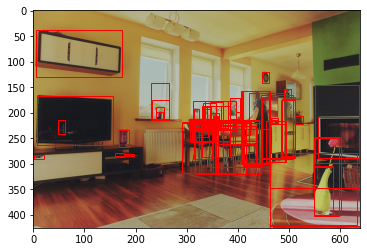

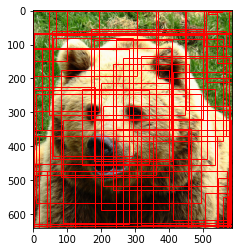

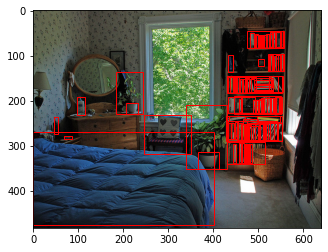

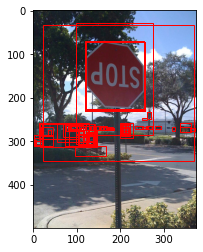

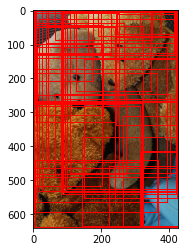

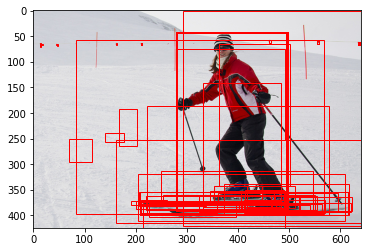

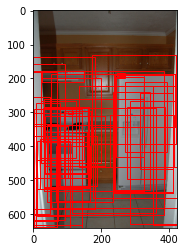

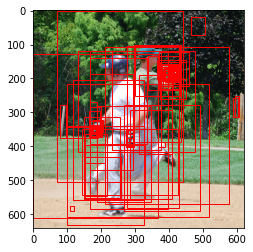

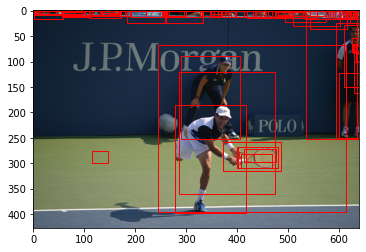

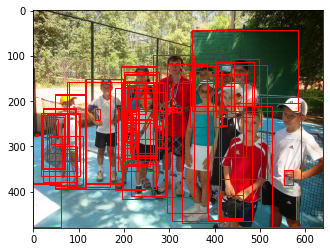

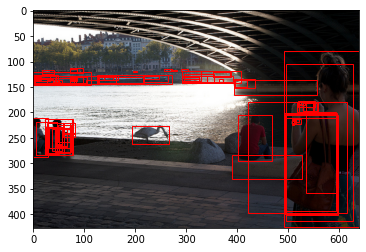

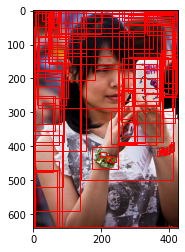

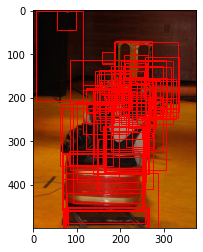

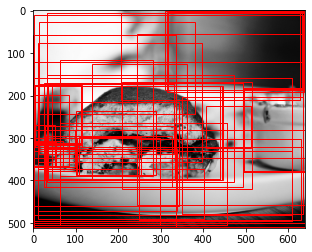

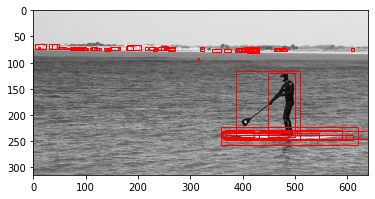

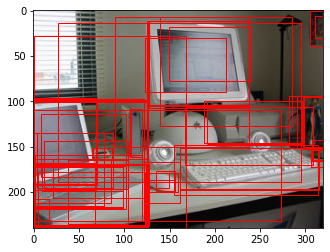

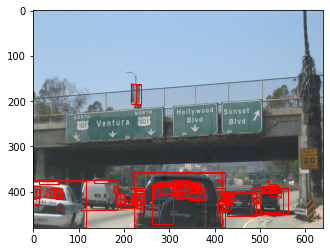

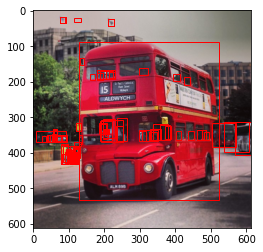

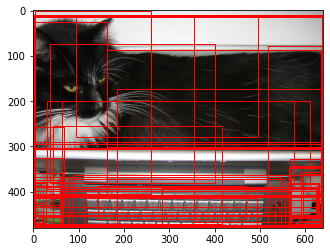

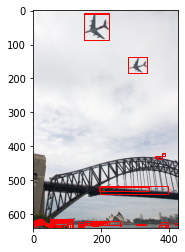

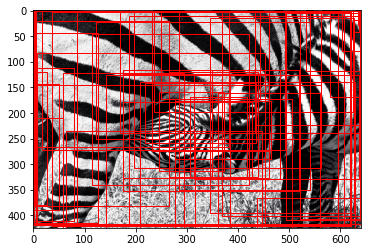

In [5]:
#args_str = 'data/split --dataset split_coco --model tf_efficientdet_d0 --num-gpu 4 --batch-size 1'
args_str = 'data --model tf_efficientdet_d7 --num-gpu 4 --batch-size 1'
args,_ = parser.parse_known_args(args=args_str.split())

validate(args)